In [1]:
import numpy as np
from scipy import stats
import datetime
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from workalendar.usa import UnitedStates
from operator import itemgetter

import pandas as pd

In [28]:
products = list(np.load('office_products_data.npy', allow_pickle=True))
# products = list(np.load('product_electronics_50_price_history.npy', allow_pickle=True))
sample_product = products[20]

In [92]:
class Product:
    '''
    Modularize each product to store each feature as an attribute of a class. 
    Attributes: 
        Mean, Max, Mode, Standard Deviation, Normalized Amazon time Price History
    Functions:
        Holidays overlaid, Ability to detect sales, Derivative of Price History, SCatter plot with various features
        Regression Function
    '''
    
    def __init__(self, product_dict):
        # TODO: Add more asserts
        #TODO: Remove multiple prices for same day and change precision to the year, month and day
        assert isinstance(product_dict, dict)
        
        self.product_dict = product_dict
        
        d = {'amazon_time': product_dict['data']['AMAZON_time'], 'amazon_price': product_dict['data']['AMAZON']}
        self.df = pd.DataFrame(data=d)
        self.df = self.remove_nan(self.df)
        self.df['normalized'] = self.normalize_prices(self.df['amazon_price'])
        self.df['standardized'] = self.standardize_prices(self.df['amazon_price'])
        
        # Check that price history is long enough to calculate derivative
        if self.df['amazon_price'].count() > 2:
            self.df['derivative'] = self.derivative_prices(self.df['amazon_price'])        

        self.mean = self.df['amazon_price'].mean()
        self.max = self.df['amazon_price'].max()
        # self.mode = stats.mode(self.df['amazon_price'])
        # self.std = stats.tstd(self.df['amazon_price'])

    def price_holiday_correlation(self, year=2018, plot=False):
        '''Plot price history's correlation with a country's holidays

        :param year: Year for which prices are to be plotted 
        :type year: int
        :param plot: Indicates whether to plot the data or not 
        :type plot: bool
        :return: List of dates for which prices are available and their corresponding prices
        :rtype: list
        '''
        
        assert isinstance(year, int) and year <=2019
        #Plot the amazon time price history for the given year and overlay a graph of holidays on top of that
        # year_index = [iter_date.year == year for iter_date in self.product_dict['data']['AMAZON_time']]
        # year_prices = list(self.df['amazon_price'])[np.where(year_index)]
        # year_dates = self.product_dict['data']['AMAZON_time'][np.where(year_index)]
        # print('Number of price data points for the year %d: %d'% (year, len(year_dates)))
        df_year = self.df[['amazon_time', 'amazon_price']][self.df['amazon_time'].dt.year == year]
        
        cal=UnitedStates()
        us_holidays, _ = zip(*cal.holidays(year))
        
        holiday_prices = self.df[['amazon_time', 'standardized']][self.df['amazon_time'].dt.date.isin(us_holidays)]
        
        if plot:
            #Plot the dates against prices
            fig, ax = plt.subplots(constrained_layout=True)
            locator = mdates.AutoDateLocator()
            formatter = mdates.AutoDateFormatter(locator)
            ax.xaxis.set_major_locator(locator)
            ax.xaxis.set_major_formatter(formatter)
            
            #Plot holiday lines
            for holiday in us_holidays:
                plt.axvline(holiday, color = 'r')

            ax.plot(df_year['amazon_time'], df_year['amazon_price'], '.')
            ax.set_title('%d Price vs Holidays plotter' % (year))
        
            ax.plot(holiday_prices['amazon_time'], holiday_prices['standardized'], 'x', color = 'g')
            
#         return df_year['amazon_time'], df_year['amazon_price']
        return holiday_prices

    def remove_nan(self, product):
        '''Remove nan prices from price history

        :param product: price history 
        :type product: pd.DataFrame or pd.Series
        :return: product with nan entries removed
        :rtype: pd.DataFrame or pd.Series
        '''
        assert isinstance(product, (pd.DataFrame,pd.Series))

        return product.dropna()

    def standardize_prices(self, x):
        '''Given an iterable list of prices, standardize the prices
        Data is centered at 0 mean with unit variance

        :param x: price history
        :type x: (list, np.ndarray, pd.Series)
        :return: z-score standardized price history
        :rtype: np.ndarray
        '''

        assert isinstance(x, (list, np.ndarray, pd.Series))
        assert all(~np.isnan(i) for i in x)

        return stats.zscore(x)

    def normalize_prices(self, x):
        '''Normalize an iterable list of prices to range (0,1)

        :param x: price history
        :type x: (list, np.ndarray, pd.Series)
        :return: normalized price history
        :rtype: np.ndarray
        '''
        assert isinstance(x, (list, np.ndarray, pd.Series))
        assert all(~np.isnan(i) for i in x)

        return (x-np.min(x))/(np.max(x) - np.min(x))
    
    def derivative_prices(self, x):
        '''Derivative of price history
        
        :param x: price history
        :type x: (list, np.ndarray, pd.Series)
        # :return: derivative of price history
        :rtype: pd.Series
        '''
        assert isinstance(x, (list, np.ndarray, pd.Series))
        assert all(~np.isnan(i) for i in x)
        
        return pd.Series(np.gradient(x.values), x.index, name='gradient')

    def saleDetector(self, threshold=0.8):
        """
        To detect the sale price and timing
        :param: threshold
        :type: dict
        :return: two list that are price and time 
        """
        # data = product['data']
        # times = data['AMAZON_time']
        # price = data['AMAZON']
        assert isinstance(threshold, (int, float))
        assert 0 <= threshold <= 1

        times = self.df['amazon_time'].values
        price = self.df['amazon_price'].values
        assert len(times) == len(price)
        
        meanValue = np.nanmean(price)
        sale_price = list()
        sale_time = list()
        for i in range(len(price)):
            if price[i] < meanValue*threshold:
                sale_price.append(price[i])
                sale_time.append(times[i])
        return sale_price, sale_time

          amazon_time  amazon_price  normalized  standardized  derivative
0 2011-03-24 16:00:00         15.23    0.860095      3.895941      -1.190
1 2011-05-05 15:00:00         14.04    0.765501      3.212910      -0.815
2 2011-05-06 15:00:00         13.60    0.730525      2.960360      -0.140
3 2011-05-21 15:00:00         13.76    0.743243      3.052196       0.000
4 2011-05-27 11:00:00         13.60    0.730525      2.960360       0.140
----------------------------


,amazon_time,standardized
1167,2014-07-04 12:00:00,-0.598291
1214,2014-11-11 03:00:00,-0.845101


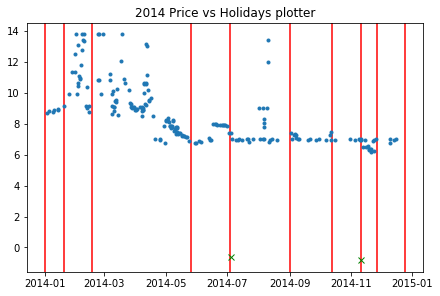

In [93]:
product_object = Product(sample_product)
# print(product_object.amazon_price_history)
print(product_object.df.head())
# print(product_object.mean)
# print(product_object.max)
# print(product_object.derivative_prices(product_object.df['amazon_price']))

# print(product_object.mode)
# print(product_object.std)
print('----------------------------')
product_object.price_holiday_correlation(2014, True)

In [30]:
a = np.array([1, 3, 4, 5, 6, -1])
print(a[np.where(a > 1)])
del(dates)

[3 4 5 6]
